In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Flatten, Dense
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

# Data Input and Model Creation

In [2]:
"""
Function takes in preprocessed data (classes balanced, duplicates removed, NOT normalized)
The standard scaler has to be exported so it is important to normalize the data here

Change the paths in trainFull and TestFull to desired preprocessedData

"""
def getPreprocessedData():
    #Read in preprocessed data
    trainFull = pd.read_csv("PreprocessedData/trainFull.csv", delimiter = ";")
    testFull = pd.read_csv("PreprocessedData/testFull.csv", delimiter = ";")

    #Randomize samples
    trainFull = trainFull.sample(len(trainFull))
    testFull = testFull.sample(len(testFull))

    #Reduce features and extract labels
    trainX = trainFull.iloc[:,:-2]
    trainY = trainFull.iloc[:,-1]
    testX = testFull.iloc[:,:-2]
    testY = testFull.iloc[:,-1]
    #Standard scale training data
    trainScaler = StandardScaler()
    trainScaler.fit(trainX)
    trainX = trainScaler.transform(trainX)

    #Export standard scale
    #dump(trainScaler, 'standardScaler.bin', compress=True)

    #Standard scale testing data
    testScaler = StandardScaler()
    testScaler.fit(testX)
    testX = testScaler.transform(testX)

    #Reshape data to 3D for CNN
    trainX = trainX[..., None]
    trainY = trainY[..., None]
    testX = testX[..., None]
    testY = testY[..., None]

    return trainX, trainY, testX, testY


In [3]:
"""
This method contains the architecture for the CNN used.
It uses tensorflow sequential as the basis to crease the model.

@param numConvFilters: number of convolutional filters in the 2nd hidden layer. We recommend >32 to upscale.
@param dropout: fraction of nodes dropped out of the Max Pooling layer.
@param numDenseNodes: number of dense nodes in the feed forward layer.

Recommended:
numConvFilters = 242
dropout = .215
numDenseNodes = 190

"""
def newModel(numConvFilters = 242, dropout = .215, numDenseNodes = 190):
    #Create new sequential model
    model = Sequential()

    #Add 1D Convolutional layers
    model.add((Conv1D(filters=32, kernel_size=3, activation='relu')))
    model.add((Conv1D(filters=numConvFilters, kernel_size=3, activation='relu')))
    #Add Max Pooling layer
    model.add((MaxPooling1D(pool_size=2)))
    #Apply dropout
    model.add(Dropout(dropout))
    #Flatten model
    model.add(Flatten())
    #Add fully connected dense layer
    model.add(Dense(numDenseNodes, activation='sigmoid'))
    #Add output node
    model.add(Dense(1, activation='sigmoid'))
    
    #Define optimizer
    adam = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    #Compile model
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve='PR'),                                                                                         tf.keras.metrics.PrecisionAtRecall(0.8)])
    return model

In [7]:
trainX, trainY, testX, testY = getPreprocessedData()
model = newModel()
model.fit(trainX, trainY, epochs = 3, batch_size=20, verbose = 1)

/var/folders/fr/03zv9zcj7j146mrr4jsb58kw0000gn/T/ipykernel_40716/2525749527.py:37: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  trainY = trainY[..., None]
/var/folders/fr/03zv9zcj7j146mrr4jsb58kw0000gn/T/ipykernel_40716/2525749527.py:39: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  testY = testY[..., None]


Epoch 1/3
719/719 [==============================] - 40s 53ms/step - loss: 0.5711 - auc_1: 0.7682 - precision_at_recall_1: 0.6565
Epoch 2/3
719/719 [==============================] - 30s 41ms/step - loss: 0.5203 - auc_1: 0.8208 - precision_at_recall_1: 0.7013
Epoch 3/3
719/719 [==============================] - 24s 33ms/step - loss: 0.5024 - auc_1: 0.8349 - precision_at_recall_1: 0.7145


# Validation and Analysis 

In [5]:
#create confusion Matrix
def confusionMatrix(model, testX, testY):
    pred = model.predict(testX)
    predy = []
    for i in range(0,len(pred)):
        if pred[i] >= .5:
            predy.append(1)
        else:
            predy.append(0)
        
    print(confusion_matrix(testY,predy))
    
#Calculates our model metrics
def modelMetrics(testX, testY, model):
    y_scores = model.predict(testX)
    precision, recall, thresholds = precision_recall_curve(testY, y_scores)
    rec80 = np.max(recall[precision >= .8])
    print("Recall at 80% Precision: " +str(rec80))
    aucPR = auc(recall, precision)
    print("PR-AUC: " + str(aucPR))
    
    return rec80, aucPR, 

#plots a PR curve
def PRplot(testX, testY, model):
    y_scores = model.predict(testX)
    precision, recall, thresholds = precision_recall_curve(testY, y_scores)
    plt.plot(recall, precision)
    plt.title("PR curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")

Recall at 80% Precision: 0.6733648542159181
PR-AUC: 0.8473881260625731
[[1961  577]
 [ 648 1890]]


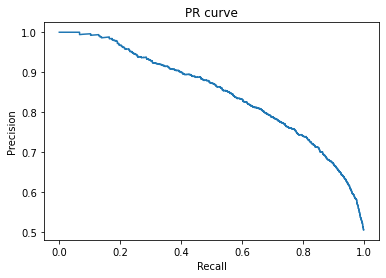

In [6]:
modelMetrics(testX, testY, model)
confusionMatrix(model, testX, testY)
PRplot(testX, testY, model)